In [2]:
import csv
import os
import numpy as np
from scipy.optimize import *  #curve_fit
from numpy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from scipy.ndimage.interpolation import rotate
from scipy.signal import savgol_filter
import cv2
%matplotlib notebook



In [84]:
corr = np.load("C:/Users/andre/Desktop/SPECS_IMAGE_TRANSFORMATION/HMV_mode/corrected.npy")
raw = np.load("C:/Users/andre/Desktop/SPECS_IMAGE_TRANSFORMATION/HMV_mode/raw.npy")

raw = raw.astype(np.float32)
corr = corr.astype(np.float32)



Ek = 510   # [eV], rr = (Ek - WF)/Ep = 1.02
Ep = 500   # [eV]
WF = 0   # [eV]
ERange = [475 , 545]   # [eV], (ERange - Ek)/Ep = -0.07 0.07
aRange = [-15 , 15]   # [deg]
De1                = 0.00333333   # [eV/(mm_y Ep)]
aInner             = 1   # [deg]

eShift             = [-0.07 , 0 , 0.07]   # [Ep]
Da1                = [-0.03934 ,4.346 ,1]   # [mm_z/deg]
Da3                = [-7.529, -4.362 ,0]   # [mm_z/deg^3]
Da5                = [8.141, 3.732, 0]   # [mm_z/deg^5]
Da7                = [-27.74 ,-5.082 , 0]   # [mm_z/deg^7]
pixel_size         = [0.0099, 0.0099]   # [mm]

Detector_size = [1302, 1040] ## pixels



In [82]:
#Test


Ek = 9
Ep = 3
WF = 4.5820
DDR = 0
RR = 1.4727
De1 = 0.0033
aInner             = 7
eShift = [-0.05, 0 , 0.05]
aRange = [-7 , 7]   # [deg]
pixel_size = [0.00645, 0.00645]
Detector_size = [1302, 1040] ## pixels

Da1 = [1.25898, 1.44466, 1.57817]
Da3 = [-0.106722, -0.0435653, 0.0561742]
Da5 = [-0.0462102, -0.0600667, -0.107655]
Da7 = [0, 0, 0]

In [77]:
E_calc

array([475., 510., 545.])

In [87]:
Ene_axis = np.linspace(Ek - Ep*0.07, Ek+Ep*0.07, Detector_size[0])
Ene_axis

array([475.        , 475.05380477, 475.10760953, ..., 544.89239047,
       544.94619523, 545.        ])

No handles with labels found to put in legend.


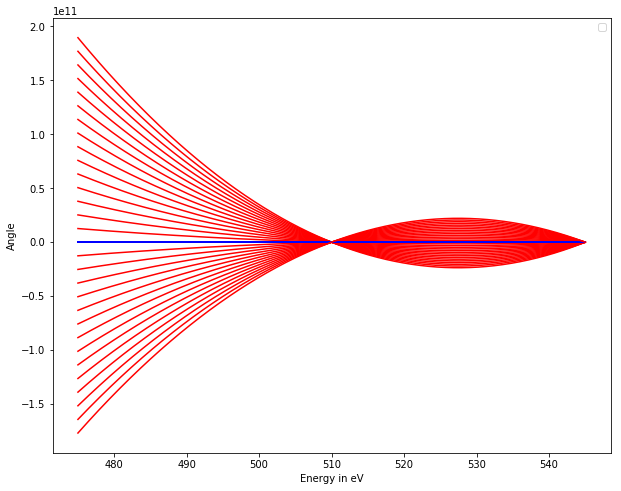

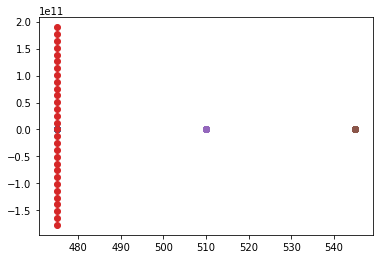

In [85]:
x_mm = np.arange(0,(Detector_size[0]))*pixel_size[1]  ## axis in mm
E_calc = np.array([Ek + eShift[0]*Ep, Ek ,  Ek + eShift[2]*Ep])
Ene_axis =  np.linspace(Ek - Ep*0.07, Ek+Ep*0.07, Detector_size[0]) ### Need to be adjusted still

ang_axis = np.arange(aRange[0],aRange[1],1)
v_mm = np.arange(0,(Detector_size[1]))*pixel_size[1]



zEk0 = Da1[0]*ang_axis + ang_axis*Da3[0]**3 + ang_axis*Da5[0]**5 + ang_axis*Da7[0]**7

zEk1 = Da1[1]*ang_axis + ang_axis*Da3[1]**3 + ang_axis*Da5[1]**5 + ang_axis*Da7[1]**7

zEk2 = Da1[2]*ang_axis + ang_axis*Da3[2]**3 + ang_axis*Da5[2]**5 + ang_axis*Da7[2]**7

Ek0 = np.zeros_like(ang_axis) + E_calc[0]
Ek1 = np.zeros_like(ang_axis) + E_calc[1]
Ek2 = np.zeros_like(ang_axis) + E_calc[2]


##polyfit
plt.figure(figsize=(10,8))
for i in range(0,len(Ek0)):
    ang_or = [ang_axis[i]]*3
    ang_tr = [zEk0[i], zEk1[i], zEk2[i]]
    ene = E_calc
    poly_or = np.poly1d(np.polyfit(ene, ang_or, 2))
    poly_tr = np.poly1d(np.polyfit(ene, ang_tr, 2))
    
    plt.plot(Ene_axis, poly_or(Ene_axis),'b-')
    plt.plot(Ene_axis, poly_tr(Ene_axis),'r')
    
plt.xlabel("Energy in eV")
plt.ylabel("Angle")
plt.legend()
plt.show()

plt.figure()
plt.scatter(Ek0, ang_axis)
plt.scatter(Ek1, ang_axis)
plt.scatter(Ek2, ang_axis)

plt.scatter(Ek0+0.01, zEk0)
plt.scatter(Ek1+0.01, zEk1)
plt.scatter(Ek2+0.01, zEk2)

# plt.ylim([-9,9])

plt.show()

In [60]:
poly_or = np.polyfit(ene, ang_or, 2)
poly_or(10)

TypeError: 'numpy.ndarray' object is not callable

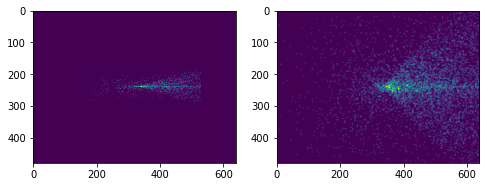

In [75]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(corr)
plt.subplot(1,2,2)
plt.imshow(raw)
plt.show()

<IPython.core.display.Javascript object>


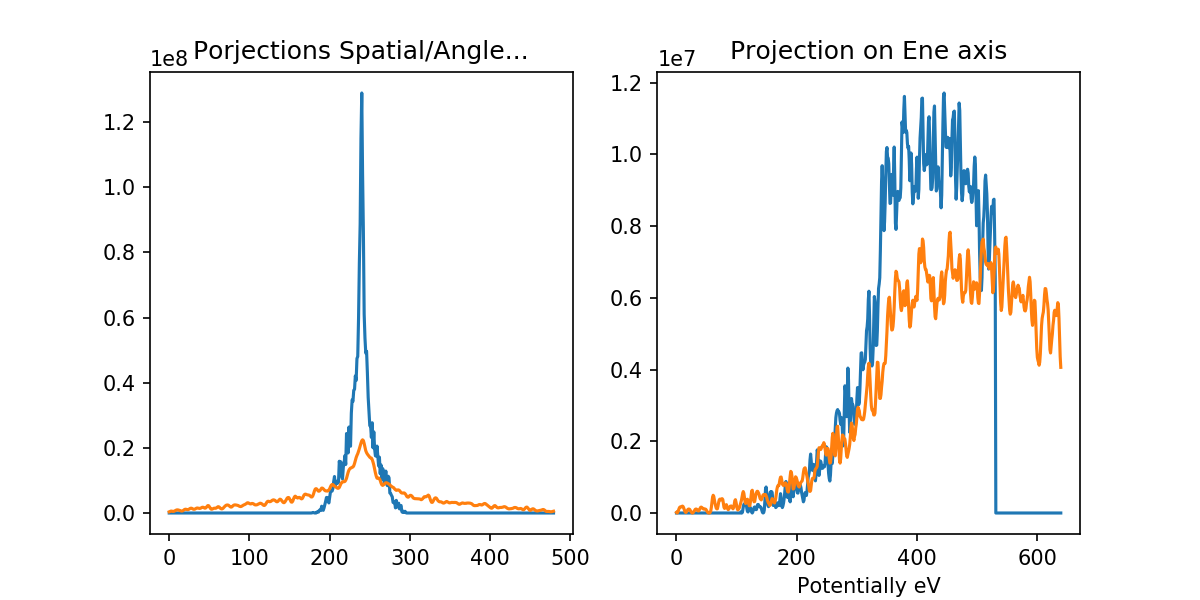

In [9]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title("Porjections Spatial/Angle...")
plt.plot(np.sum(corr, axis = 1))
plt.plot(np.sum(raw, axis = 1))
plt.subplot(1,2,2)
plt.title("Projection on Ene axis")
plt.plot(np.sum(corr, axis = 0))
plt.plot(np.sum(raw, axis = 0))
plt.xlabel("Potentially eV")

plt.show()

In [10]:
pts1 = np.float32([[0,35],[640,35],[640,450],[0,450]])
pts2 = np.float32([[107,0],[530,0],[530,480],[107,480]])

#pts1 = np.float32([[0,33],[640,0],[640,480],[0,450]])
#pts2 = np.float32([[107,0],[530,0],[530,480],[107,480]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(raw,M,(640,480))
print(M)

[[ 6.60937500e-01  3.56659147e-15  1.07000000e+02]
 [ 1.06165077e-15  1.15662651e+00 -4.04819277e+01]
 [ 4.96022494e-18  1.08149167e-17  1.00000000e+00]]


<IPython.core.display.Javascript object>


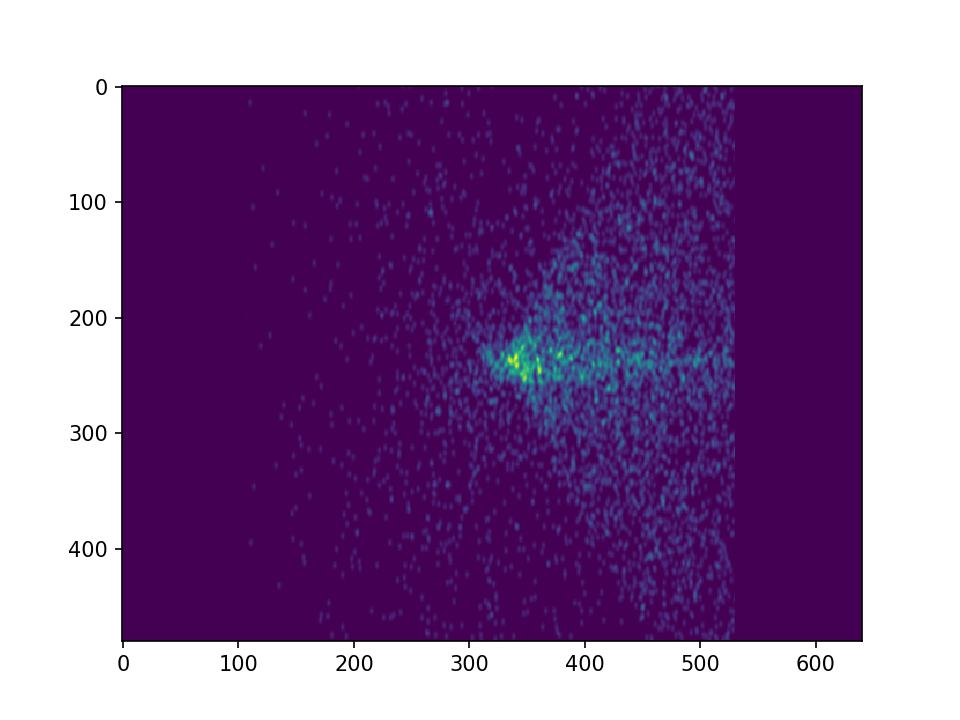

In [11]:
plt.figure()
plt.imshow(dst)
plt.show()

<IPython.core.display.Javascript object>


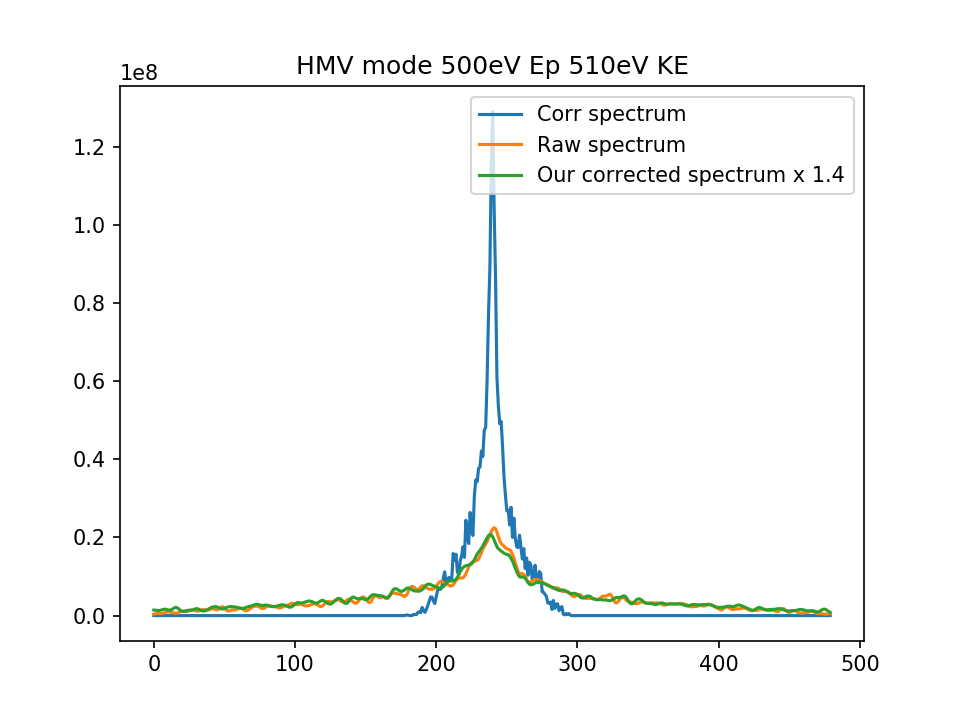

In [14]:
plt.figure()
plt.title("HMV mode 500eV Ep 510eV KE")
plt.plot(np.sum(corr, axis = 1), label = "Corr spectrum")
plt.plot(np.sum(raw, axis = 1), label = "Raw spectrum")
plt.plot(1.4*np.sum(dst, axis = 1), label = "Our corrected spectrum x 1.4")
#plt.xlabel("longitu")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


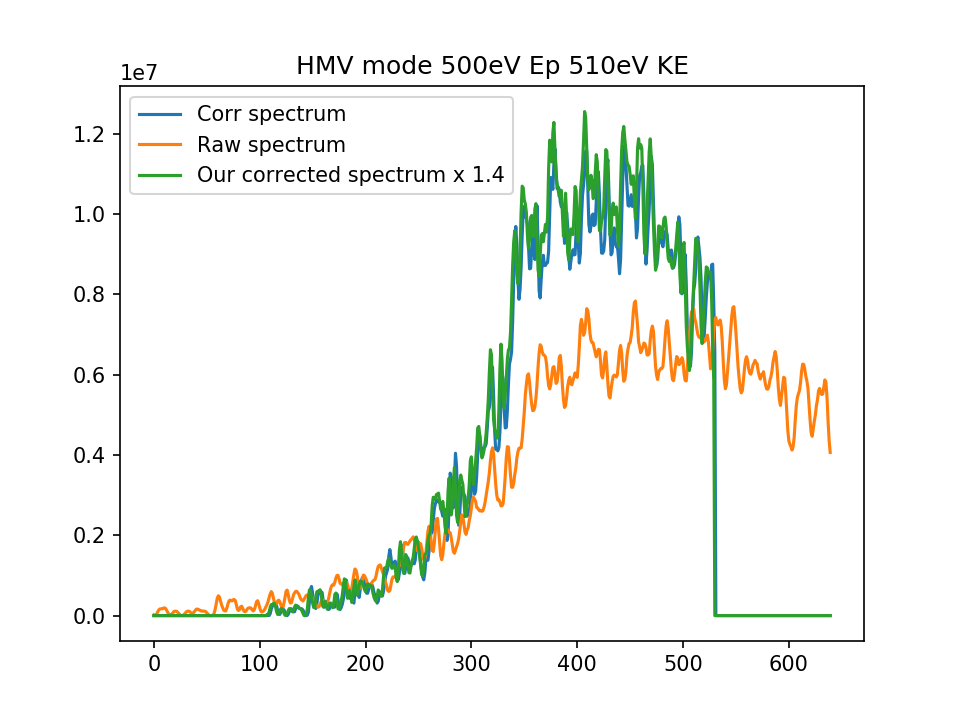

In [13]:
plt.figure()
plt.title("HMV mode 500eV Ep 510eV KE")
plt.plot(np.sum(corr, axis = 0), label = "Corr spectrum")
plt.plot(np.sum(raw, axis = 0), label = "Raw spectrum")
plt.plot(1.4*np.sum(dst, axis = 0), label = "Our corrected spectrum x 1.4")
#plt.xlabel("longitu")
plt.legend()
plt.show()

In [ ]:
## High order correction:


